In [ ]:
#vncoreNLP
!pip install deplacy vncorenlp

from underthesea import word_tokenize
import pandas as pd
import string



In [4]:
from vncorenlp import VnCoreNLP

vnp=VnCoreNLP("VnCoreNLP/VnCoreNLP-1.1.1.jar",annotators="wseg,pos,parse")
nlp=lambda t:"".join(["\n".join(["\t".join([str(v["index"]),v["form"],"_",v["posTag"],v["posTag"],"_",str(v["head"]),v["depLabel"],"_","_"]) for v in s])+"\n\n" for s in vnp.annotate(t)["sentences"]])

with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = [line.strip() for line in file]
    
noi_dung= 'Hợp đồng lao động là sự thỏa thuận giữa người lao động và người sử dụng lao động về việc làm có trả công, tiền lương, điều kiện lao động, quyền và nghĩa vụ của mỗi bên trong quan hệ lao động.'
tokens = word_tokenize(noi_dung)
# Remove stopwords
filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
# Extract unique keywords (remove duplicates)
keywords = list((filtered_tokens))
# Print the extracted keywords
print(keywords)


annotated_text = vnp.annotate(noi_dung)
# Iterate through the sentences and words and print them
for sentence in annotated_text['sentences']:
    for word in sentence:
        print(f"Word: {word['form']}, POS: {word['posTag']}, Head: {word['head']}, Dep Label: {word['depLabel']}")

['Hợp đồng', 'lao động', 'thỏa thuận', 'lao động', 'lao động', 'việc làm', 'công', 'tiền lương', 'lao động', 'quyền', 'nghĩa vụ', 'quan hệ', 'lao động']
Word: Hợp_đồng, POS: N, Head: 3, Dep Label: sub
Word: lao_động, POS: N, Head: 1, Dep Label: nmod
Word: là, POS: V, Head: 0, Dep Label: root
Word: sự, POS: N, Head: 3, Dep Label: vmod
Word: thoả_thuận, POS: V, Head: 4, Dep Label: nmod
Word: giữa, POS: N, Head: 5, Dep Label: loc
Word: người, POS: N, Head: 6, Dep Label: nmod
Word: lao_động, POS: V, Head: 7, Dep Label: nmod
Word: và, POS: Cc, Head: 4, Dep Label: nmod
Word: người, POS: N, Head: 4, Dep Label: nmod
Word: sử_dụng, POS: V, Head: 10, Dep Label: nmod
Word: lao_động, POS: N, Head: 11, Dep Label: dob
Word: về, POS: E, Head: 4, Dep Label: nmod
Word: việc_làm, POS: N, Head: 13, Dep Label: pob
Word: có, POS: V, Head: 4, Dep Label: nmod
Word: trả, POS: V, Head: 15, Dep Label: vmod
Word: công, POS: N, Head: 16, Dep Label: dob
Word: ,, POS: CH, Head: 17, Dep Label: punct
Word: tiền_lương

In [5]:

!pip install spacy
!python -m spacy download en_core_web_sm



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 12.8/12.8 MB 3.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [7]:
# import wikipedia sentences
candidate_sentences = pd.read_excel("12k_data_with_keywords.xlsx")
candidate_sentences.shape

(13674, 7)

In [9]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [10]:
entity_pairs = []

for i in tqdm(candidate_sentences["Câu trả lời"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 13674/13674 [07:52<00:00, 28.92it/s]


In [20]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [21]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['Câu trả lời'])]


100%|██████████| 13674/13674 [07:24<00:00, 30.78it/s]


In [23]:
pd.Series(relations).value_counts()[:50]


giờ hành    983
gọi         798
định        751
số          633
dẫn         502
tổng        495
Đề nghị     327
động        295
hệ          245
bảo         241
trợ         232
Nam số      201
cung        186
thì         162
gia         153
tại         150
quyết       149
Việt        136
thể         128
này         122
hưởng       114
cấp         112
công ty     112
đáp         111
hoàn        110
được        110
biết        110
BHXH        100
tôi          98
mức          93
tiếp         93
có           92
do           82
nhận hồ      82
bạn          80
đài          80
trên         79
sổ           78
định về      73
Bạn          72
BHYT         70
thoại        69
tháng        68
tâm          63
vậy          61
kiểm         60
nhất         60
với          60
sung         59
hiện         59
dtype: int64

In [24]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

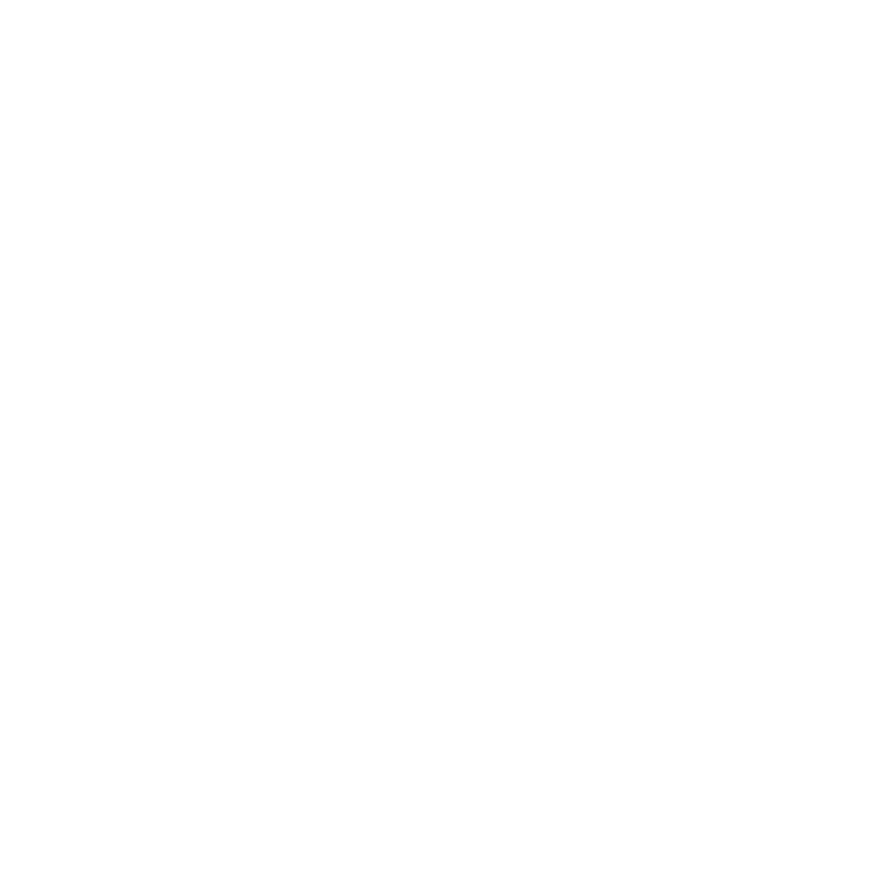

In [25]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()